In [10]:
import os

import tweepy

#https://medium.freecodecamp.org/how-to-build-a-twitter-sentiments-analyzer-in-python-using-textblob-948e1e8aae14
from textblob import TextBlob
from datetime import datetime
from pytz import timezone

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from IPython.core.display import clear_output
from time import time

import random
from numpy.random import choice
from shapely.affinity import affine_transform
from shapely.geometry import shape, mapping, Point, Polygon
import json

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
TWITTER_KEY = os.getenv('TWITTER_KEY')
TWITTER_SECRET = os.getenv('TWITTER_SECRET')
TWITTER_TOKEN = os.getenv('TWITTER_TOKEN')
TWITTER_TOKEN_SECRET = os.getenv('TWITTER_TOKEN_SECRET')

In [3]:
auth = tweepy.OAuthHandler(TWITTER_KEY, TWITTER_SECRET)
auth.set_access_token(TWITTER_TOKEN, TWITTER_TOKEN_SECRET)

api = tweepy.API(auth)

In [97]:
#Pre-calculated triangulation to speed-up process:
with open('docker/nyc-borough-processed.geojson') as json_file:  
    nyc_boroughs = json.load(json_file)
    
for boro in nyc_boroughs['features']:
    boro['geometry'] = shape(boro['geometry'])

#Based on https://codereview.stackexchange.com/questions/69833/generate-sample-coordinates-inside-a-polygon
def random_point_in_polygon(transforms, areas):
    total = sum(areas)
    transform = transforms[choice(len(transforms),
                                  p=[x/total for x in areas])]
    x, y = [random.random() for _ in range(2)]
    if x + y > 1:
        p = Point(1 - x, 1 - y)
    else:
        p = Point(x, y)
    return affine_transform(p, transform)
    
def random_point_in_box(box):
    minx, miny, maxx, maxy = box.bounds
    center = box.centroid
    return Point(random.triangular(minx, maxx, center.x), random.triangular(miny, maxy, center.y))

def which_borough(point):
    for boro in nyc_boroughs['features']:
        if boro['geometry'].intersects(point):
            return boro['properties']['boro_name']
    return False

stop_words = stopwords.words('english')
stop_words.extend(['com', 'from', 'subject', 're', 'edu', 'use',
                   'not', 'would', 'say', 'could', '_', 'be', 'know',
                   'good', 'go', 'get', 'do', 'done', 'try', 'many',
                   'some', 'nice', 'thank', 'think', 'see', 'rather',
                   'easy', 'easily', 'lot', 'lack', 'make', 'want',
                   'seem', 'run', 'need', 'even', 'right', 'line',
                   'even', 'also', 'may', 'take', 'come'])

#nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']

def get_words(tweet):
    
    text = tweet['text'] if not tweet['truncated'] else tweet['extended_tweet']['full_text']
    entities = tweet['entities'] if not tweet['truncated'] else tweet['extended_tweet']['entities']
    
    hashtags = ['#'+x['text'].lower() for x in entities['hashtags']]
    user_mentions = ['@'+x['screen_name'].lower() for x in entities['user_mentions']]
    urls = [x['url'].lower() for x in entities['urls']]
    
    if 'media' in entities:
        media = [x['url'].lower() for x in entities['media']]
        all_entities = hashtags + user_mentions + urls + media
    else:
        all_entities = hashtags + user_mentions + urls
    
    #Remove entities
    clean_text = ' '.join([x for x in text.split() if x.lower() not in all_entities])
    
    #Preprocess
    clean_text = simple_preprocess(clean_text)
    
    #Remove stop words
    clean_text = [word for word in clean_text if word not in stop_words]
    
    # Parse the sentence using the loaded 'en' model object `nlp`. Extract the lemma for each token and join
    clean_text = nlp(' '.join(clean_text)) 
    clean_text = {token.lemma_ for token in clean_text if token.pos_ in allowed_postags}
    
    #Remove stop words again
    clean_text = [word for word in clean_text if word not in stop_words]
    
    return clean_text
    
def process_coordinates(tweet):
    
    boro_list = ['Manhattan', 'Brooklyn', 'Bronxs', 'Queens', 'Staten Island']
    nyc_ids = ['27485069891a7938','94965b2c45386f87']
    tweet['coords_source'] = 'Randomized'
        
    if tweet['coordinates']:
        #Check if inside NYC
        coords = shape(tweet['coordinates'])
        boro_name = which_borough(coords)
        if boro_name:
            tweet['coords_source'] = 'Origin'
            tweet['coordinates'] = mapping(coords)
            tweet['borough'] = boro_name
        else: 
            tweet['coords_source'] = False    
            
    elif tweet['place']['place_type'] == 'poi':
        #Point of interest.
        coords = random_point_in_box(shape(tweet['place']['bounding_box']))
        boro_name = which_borough(coords)
        if boro_name:
            tweet['coordinates'] = mapping(coords)
            tweet['borough'] = boro_name
        else: 
            tweet['coords_source'] = False
        
    elif (tweet['place']['place_type'] == 'neighborhood') & any(tweet['place']['full_name'].endswith(boro) for boro in boro_list):
        #Place is a neigborhood in a NYC borough. Full name is [Neigborhood], [City (Borough)]
        boro_name = tweet['place']['full_name'].split(', ')[-1]
        
        if boro_name not in boro_list:
            raise ValueError('{} from {} not a boro'.format(boro_name, tweet['place']['name']))
        
        boro = list(filter(lambda x: x['properties']['boro_name'] == boro_name, nyc_boroughs['features']))[0]        
        tweet['coordinates'] = mapping(random_point_in_polygon(boro['transforms'], boro['areas']))
        tweet['borough'] = boro_name
        
    elif (tweet['place']['place_type'] == 'city') & (tweet['place']['name'] in boro_list):
        #Place is a NYC borough
        tweet['coordinates'] = mapping(random_point_in_box(shape(tweet['place']['bounding_box'])))
        tweet['borough'] = tweet['place']['name']
        
    elif (tweet['place']['place_type'] == 'admin') & (tweet['place']['id'] in nyc_ids):
        #Place is NYC
        b = random.randint(0,4)
        boro = nyc_boroughs['features'][b]
        tweet['coordinates'] = mapping(random_point_in_polygon(boro['transforms'], boro['areas']))
        tweet['borough'] = boro['properties']['boro_name']
        
    else:
        tweet['coords_source'] = False
        
    return tweet

In [136]:
allTweets = []

class MyStreamListener(tweepy.StreamListener):

    latestTweets = []
    totalTweets = 0
    nExactLocation = 0
    startTime = None
    
    def on_data(self, data):
        
        status = json.loads(data)
        
        if (status['coordinates']):
            self.nExactLocation += 1
        
        status = process_coordinates(status)
        
        analysis = TextBlob(status['text'])
        
        'Mon Mar 04 22:57:20 +0000 2019',
        
        fmt = '%a %b %d %H:%M:%S %z %Y'
        created_at = datetime.strptime(status['created_at'], fmt)
        created_at = created_at.astimezone(timezone('US/Eastern'))
        status['created_at'] = created_at.strftime(fmt)
        
        status['words'] = get_words(status)
        
        text = status['text'] if not status['truncated'] else status['extended_tweet']['full_text']
        
        allTweets.insert(0,status)
        self.latestTweets.insert(0,(text, status['words'], status['created_at']))
        self.totalTweets += 1
        
        if (self.startTime is None):
            self.startTime = time()
        
        if len(self.latestTweets) > 10:
            self.latestTweets.pop()
        
        for tweet in self.latestTweets:
            print(tweet)
            
        print()
        elapsedTime = time() - self.startTime
        print('Tweets with lat/long: {} of {} ({:.2f}%); Frequency: {:.2f} tweets/s'.format(self.nExactLocation,
                                                                                              self.totalTweets,
                                                                                              self.nExactLocation/self.totalTweets*100,
                                                                                              self.totalTweets/elapsedTime))
        
        clear_output(wait=True)
        
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_error disconnects the stream
            print('error 420')
            return False

In [137]:
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)

In [138]:
#New York City bounding box according to Twitter Docs: -74,40,-73,41
#https://developer.twitter.com/en/docs/tweets/filter-realtime/guides/basic-stream-parameters
myStream.filter(locations=[-74.3,40.48,-73.7,40.93])

KeyboardInterrupt: 

In [107]:
allTweets[20]

{'created_at': 'Wed Apr 24 09:27:48 -0400 2019',
 'id': 1121043061600071680,
 'id_str': '1121043061600071680',
 'text': 'Your taxes are going to a wall@ that doesn’t affect you and a war you not fighting in and trumps golf days you aren… https://t.co/FPuxtzlcxw',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': True,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 446716502,
  'id_str': '446716502',
  'name': 'Kat 🇨🇴',
  'screen_name': 'kingkat__',
  'location': 'Queens, NY',
  'url': None,
  'description': 'LongLiveJ5❤. BA ‘16, JD ‘21',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 655,
  'friends_count': 365,
  'listed_count': 3,
  'favourites_count': 2430,
  'statuses_count': 27426,
  'created_at': 'Mon Dec 26 02:42:59 +0000 2011',
  'utc_offse

In [62]:
len(list((filter(lambda x: x is not None, map(lambda x: x['in_reply_to_status_id'], allTweets)))))

1783

In [63]:
len(list((filter(lambda x: x, map(lambda x: x['is_quote_status'], allTweets)))))

769

In [64]:
len(list((filter(lambda x: x, map(lambda x: x.get('retweeted_status',False), allTweets)))))

0

In [70]:
set((filter(lambda x: x, map(lambda x: (x['place']['place_type'] if x['place'] else 'none',
                                        x['place']['full_name'] if x['place'] else 'none',
                                        x['place']['id'] if x['place'] else 'none'), allTweets))))

{('admin', 'NEW YORK', 'b6c2e04f1673337f'),
 ('admin', 'New Jersey, USA', '65b4760a2b411e11'),
 ('admin', 'New York, NY', '27485069891a7938'),
 ('admin', 'New York, USA', '94965b2c45386f87'),
 ('admin', 'Nova Iorque, USA', '94965b2c45386f87'),
 ('admin', 'Nueva York, USA', '94965b2c45386f87'),
 ('city', 'Bayonne, NJ', '3d3c56338b6a3b4a'),
 ('city', 'Belleville, NJ', 'a227c629b631eea2'),
 ('city', 'Bergenfield, NJ', '980e30571d9d5f5d'),
 ('city', 'Bloomfield, NJ', 'dc4ad595a56393ac'),
 ('city', 'Bronx, NY', '002e24c6736f069d'),
 ('city', 'Brooklyn, NY', '011add077f4d2da3'),
 ('city', 'Caldwell, NJ', '8739d0bab792509d'),
 ('city', 'Carlstadt, NJ', 'fb3c12bc62543193'),
 ('city', 'Carteret, NJ', '71177291f1601de3'),
 ('city', 'Cedar Grove, NJ', 'f1a993cc8833f408'),
 ('city', 'Cedarhurst, NY', '15bb646d59ef405f'),
 ('city', 'Clark, NJ', '88c45dc6118d88a2'),
 ('city', 'Cliffside Park, NJ', 'ebbd168611073cb8'),
 ('city', 'Clifton, NJ', '7356b662670b2c31'),
 ('city', 'Colonia, NJ', 'dfa88de1ec

In [65]:
from functools import reduce

def reducer(x,y):
    x[y] = x.get(y, 0) + 1
    return x

In [71]:
places = reduce(reducer,map(lambda x: x['geo_source'], allTweets),{})
places

{'Randomized': 2832, 'Exact': 326, False: 1255}

## Get Delaunays triangulation of polygons, and keep only those inside polygon.

In [58]:
from shapely.geometry import shape, Point, Polygon, mapping
from shapely.ops import triangulate
import json

In [91]:
with open('nyc-zoomed.geojson') as json_file:  
    data = json.load(json_file)

In [92]:
for d in data['features']:
    d['geometry'] = shape(d['geometry'])
    areas = []
    transforms = []
    for t in triangulate(d['geometry']):
        if d['geometry'].contains(t):
            areas.append(t.area)
            (x0, y0), (x1, y1), (x2, y2), _ = t.exterior.coords
            transforms.append([x1 - x0, x2 - x0, y1 - y0, y2 - y0, x0, y0])
    d['areas'] = areas
    d['transforms'] = transforms
    print(d['properties']['boro_name'])

Manhattan
Brooklyn
Queens


In [93]:
for d in data['features']:
    d['geometry'] = mapping(d['geometry'])

In [94]:
with open('nyc-zoomed-processed.geojson', 'w') as outfile:  
    json.dump(data, outfile)

In [4]:
with open('docker/nyc-borough-processed.geojson') as json_file:  
    data = json.load(json_file)

In [98]:
point = random_point_in_polygon(data['features'][0]['transforms'], data['features'][0]['areas'])
point.coords[0]

(-73.97214146081787, 40.72611234739984)

In [ ]:
t = data['features'][0]['transforms']
a = data['features'][0]['areas']
tot = 
choice()

In [11]:
data['features'][0]['transforms']

[3.1242103733597765e-08]

In [104]:
points = [random_point_in_polygon(data['features'][1]['transforms'], data['features'][1]['areas']).coords[0] for _ in range(0,10000)]

In [105]:
x,y = zip(*points)

In [106]:
min(data['features'][0]['areas'])

6.014606975619519e-14

(40.680004170978044, 40.73899445100515)

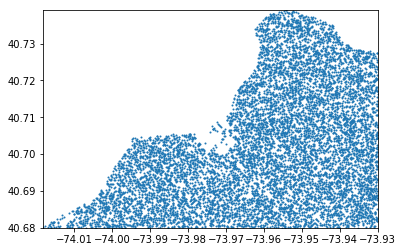

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(x,y, s=1)
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))

In [126]:
boro = shape(data['features'][4]['geometry'])

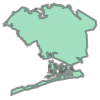

In [127]:
boro

In [38]:
data['features'][0]['transforms'][:10]

[[0.0002531123469253771,
  0.00029836639552627275,
  -0.00011142799512953161,
  -0.00030394846801584663,
  -74.04772962697038,
  40.6899153184663],
 [0.00029836639552627275,
  0.0001439077225171559,
  6.71883598641898e-05,
  -0.00011142799512953161,
  -74.04772962697038,
  40.6899153184663],
 [-6.79400946523856e-06,
  9.836355488346271e-06,
  -5.572269843412414e-05,
  -2.814995441724477e-05,
  -74.00700358904015,
  40.75923187034106],
 [9.836355488346271e-06,
  3.9301547047898566e-05,
  -7.181277945988995e-05,
  -5.572269843412414e-05,
  -74.00700358904015,
  40.75923187034106],
 [3.9301547047898566e-05,
  0.0004739891617333569,
  0.0006428809001377545,
  -7.181277945988995e-05,
  -74.00700358904015,
  40.75923187034106],
 [-3.8153547293973133e-05,
  5.726789939330956e-05,
  6.154119036239081e-05,
  -6.252985016885759e-05,
  -73.94692626404864,
  40.850528055668356],
 [-0.00013950563430853435,
  0.00016622446233327537,
  0.00018311162630624267,
  -0.000261110405453735,
  -73.9291796825

In [128]:
for d in data2['features']:
    d['geometry'] = shape(d['geometry'])

In [36]:
boro_names = [d['properties']['boro_name'] for d in data['features']]

In [129]:
from numpy.random import uniform

yes = 0
no = 0

for t in allTweets:
    if (t['coordinates'] is None) and (t['place']['place_type'] == 'city') and (t['place']['name'] in boro_names):
        coords = t['place']['bounding_box']['coordinates'][0]
        #minx = min(coords, key=lambda x: x[0])[0]
        #maxx = max(coords, key=lambda x: x[0])[0]
        #miny = min(coords, key=lambda x: x[1])[1]
        #maxy = max(coords, key=lambda x: x[1])[1]
        boro = list(filter(lambda x: x['properties']['boro_name'] == t['place']['name'], data2['features']))[0]
        #minx, miny, maxx, maxy = boro.bounds
        #x = uniform(minx, maxx)
        #y = uniform(miny, maxy)
        #while (~boro.intersects(Point([x, y]))):
        #    x = uniform(minx, maxx)
        #    y = uniform(miny, maxy)
        t['coords'] = random_point_in_polygon(boro['transforms'], boro['areas'])
        if t['coords'].within(boro['geometry']):
            yes += 1
        else:
            no += 1

In [132]:
yes

1192

In [7]:
import geopandas as gpd
%matplotlib inline

In [5]:
gdf = gpd.read_file('nyc-borough-boundaries.geojson')
gdf.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,1,Manhattan,636533240.297,359557.995733,(POLYGON ((-74.01092841268031 40.6844914725429...
1,2,Bronx,1186612476.84,462958.187796,(POLYGON ((-73.89680883223774 40.7958084451597...
2,5,Staten Island,1623920681.95,330432.867999,(POLYGON ((-74.05050806403247 40.5664220341608...
3,3,Brooklyn,1937566944.36,739945.437431,(POLYGON ((-73.86706149472118 40.5820879767934...
4,4,Queens,3044771532.61,895228.948392,(POLYGON ((-73.83668274106707 40.5949466970158...


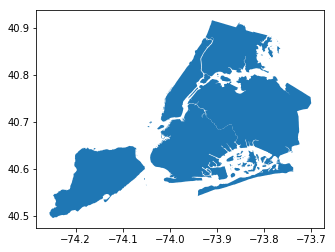

In [8]:
gdf.plot()

In [71]:
bbox_polygon = Polygon([(-74.02, 40.68),
                        (-74.02, 40.78),
                        (-73.93, 40.78),
                        (-73.93, 40.68)
                       ])

bbox_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bbox_polygon), columns=['geometry'])
bbox_gdf.crs={'init': 'epsg:4326'}

intersections = gpd.overlay(bbox_gdf, gdf, how='intersection')

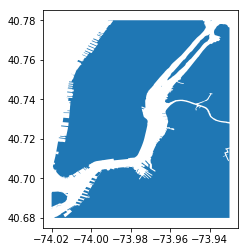

In [72]:
intersections.plot()

In [73]:
intersections.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,1,Manhattan,636533240.297,359557.995733,"(POLYGON ((-73.93923686249541 40.78, -73.93896..."
1,3,Brooklyn,1937566944.36,739945.437431,POLYGON ((-73.93000000000001 40.72767023403746...
2,4,Queens,3044771532.61,895228.948392,POLYGON ((-73.93000000000001 40.77628058594618...


In [74]:
intersections.geometry.apply(lambda x: x.type)

0    MultiPolygon
1         Polygon
2         Polygon
Name: geometry, dtype: object

In [76]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

def explode(indf):
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

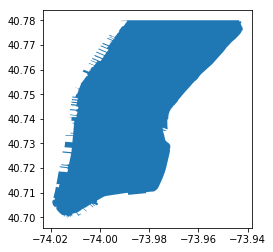

In [85]:
explode(intersections)[2:3].plot()

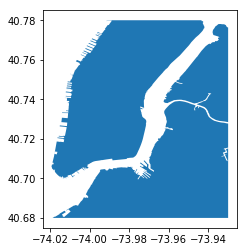

In [89]:
explode(intersections).iloc[[2,29,30],:].plot()

In [90]:
explode(intersections).iloc[[2,29,30],:].to_file('nyc-zoomed.geojson', driver='GeoJSON')

/opt/conda/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [109]:
explode(intersections).iloc[[2,29,30],:].centroid

2      POINT (-73.9859542861704 40.74466872283353)
29    POINT (-73.96018849919263 40.70182476653022)
30    POINT (-73.94058125292743 40.75058684981791)
dtype: object